## Importar las bibliotecas necesarias y preparar el entorno

In [33]:
!pip install opencv-python-headless numpy

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Crear una carpeta 'img' si no existe para guardar las imágenes resultantes
if not os.path.exists('img'):
    os.makedirs('img')

## Inciso1: Definir función para convertir y reescalar imagen

In [35]:
def convert_and_resize(image, scale):
    # Verificar que el parámetro de escala sea al menos 1
    assert scale >= 1, "El parámetro de escala 'k' debe ser al menos 1."
    
    # Convertir de RGB a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Reescalar la imagen a las dimensiones deseadas (128k x 64k)
    resized_image = cv2.resize(gray_image, (128 * scale, 64 * scale), interpolation=cv2.INTER_AREA)
    
    # Devolver la imagen reescalada
    return resized_image.astype(np.float32)  # Usar float32 para seguir el enunciado

## Inciso2: Definir función para calcular magnitud y ángulo del gradiente

In [36]:
def gradient_magnitude_and_angle(image):
    # Definir los filtros de Prewitt para Gx y Gy
    Gx_kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)
    Gy_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
    
    # Aplicar padding para mantener el tamaño de la imagen tras la convolución
    padded_image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    
    # Calcular las correlaciones Gx y Gy
    Gx = cv2.filter2D(padded_image, -1, Gx_kernel)
    Gy = cv2.filter2D(padded_image, -1, Gy_kernel)
    
    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(Gx**2 + Gy**2)
    
    # Calcular el ángulo del gradiente y convertir a grados (con módulo 180)
    angle = (np.arctan2(-Gy, Gx) * (180 / np.pi)) % 180
    
    # Quitar el padding de la imagen resultante
    magnitude = magnitude[1:-1, 1:-1]
    angle = angle[1:-1, 1:-1]
    
    # Devolver la magnitud y el ángulo
    return magnitude, angle

## Cargar imagen, aplicar funciones y visualizar resultados

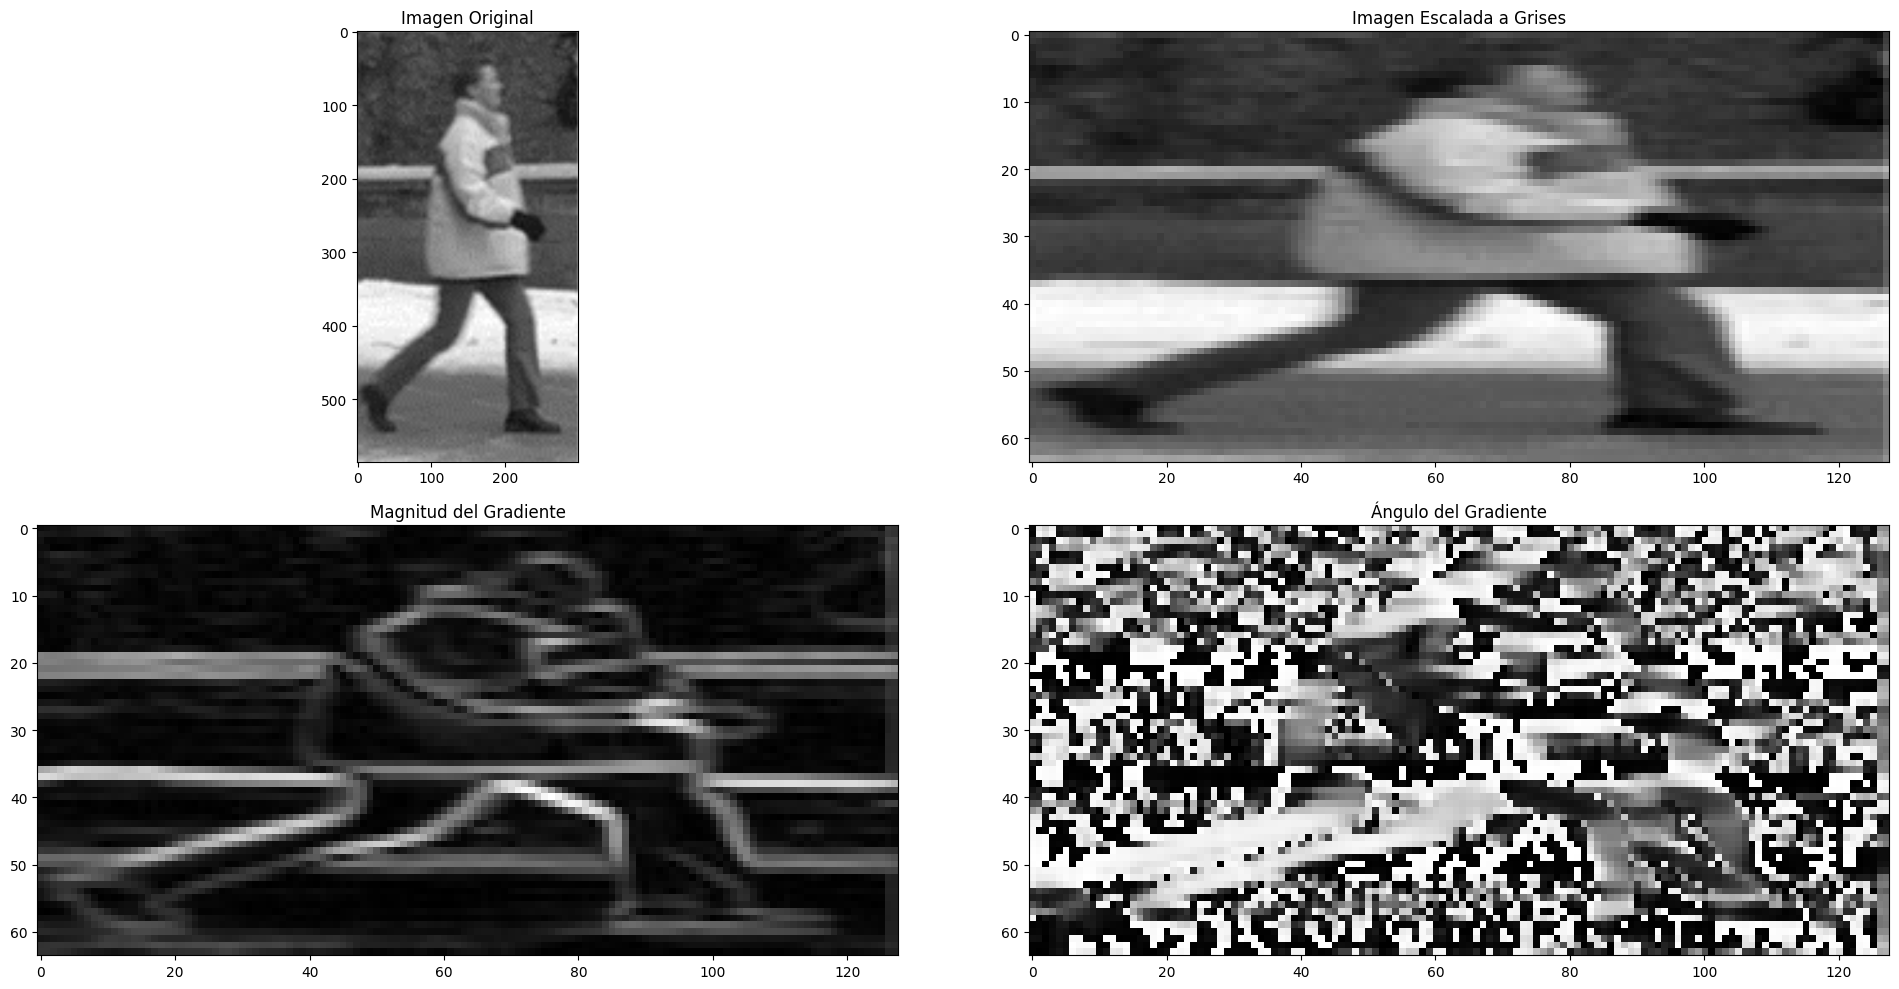

In [40]:
# Cargar la imagen (ajusta la ruta de acuerdo a tu entorno local)
image_path = './img/person.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Asegurar que esté en formato RGB para la visualización

# Aplicar la función de conversión y reescalado
scale = 1  # Este valor puede ajustarse
resized_image = convert_and_resize(image, scale)

# Aplicar la función para calcular la magnitud y el ángulo del gradiente
magnitude, angle = gradient_magnitude_and_angle(resized_image)

# Guardar y mostrar los resultados
cv2.imwrite('img/resized_image.png', resized_image)
cv2.imwrite('img/magnitude.png', magnitude)
cv2.imwrite('img/angle.png', angle)

# Visualizar la imagen original, la imagen reescalada, la magnitud y el ángulo del gradiente
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')
plt.subplot(2, 2, 2)
plt.imshow(resized_image, cmap='gray')
plt.title('Imagen Escalada a Grises')
plt.subplot(2, 2, 3)
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitud del Gradiente')
plt.subplot(2, 2, 4)
plt.imshow(angle, cmap='gray')
plt.title('Ángulo del Gradiente')
plt.tight_layout()
plt.show()